导入常用库

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 图片读取
cv2提供两种图片读取方式
- 灰度读取
- 彩色读取
方法都是相同的，在于参数不一样。

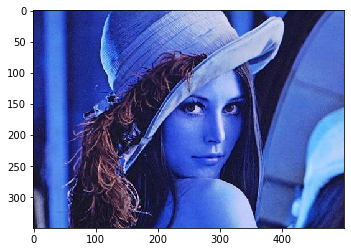

In [6]:
# 0 表示灰度读取
# 1 表示彩色读取，默认
color_img = cv2.imread('lenna.jpg', 1)
plt.imshow(color_img)
plt.show()

# 格式
图片的格式有很多种，但是直接图像的保存一般使用的都是`RGB`。
`opencv`中的图像读取为`BGR`模式，但是`matplotlib`中图像显示为`RGB`，所以图像看起来比较怪异。
这里有三种办法进行恢复
- 通过`opencv`提供的`api`直接进行图像转换
- 手动组合通道
- 借助其他图片格式进行转换，不过这个太废了

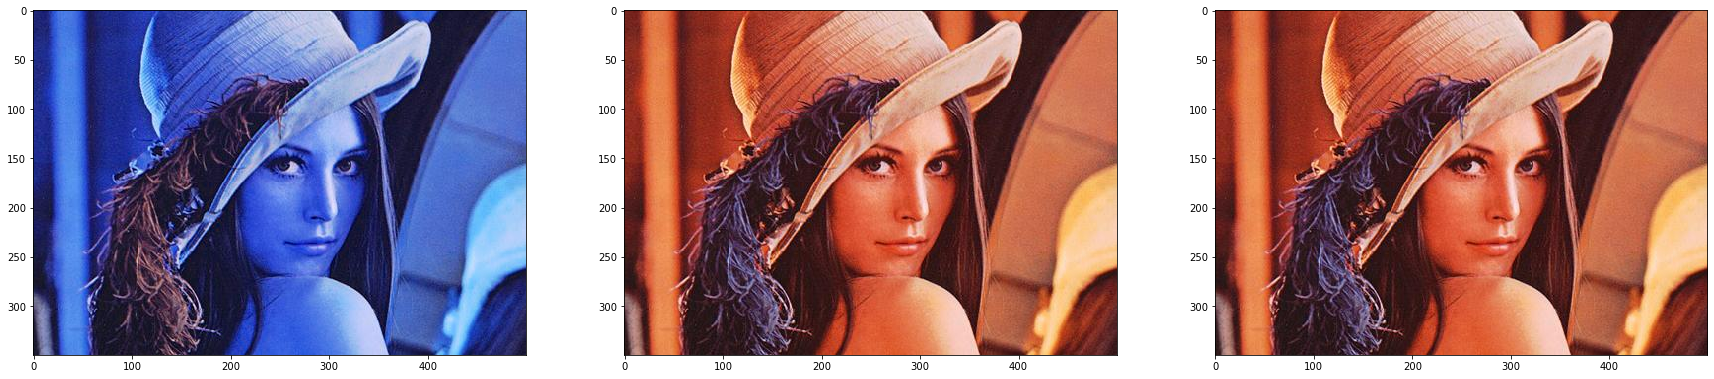

In [8]:
# api
convert_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
# merge
B,G,R = cv2.split(color_img)
merge_img = cv2.merge((R,G,B))
# draw
plt.figure(figsize=(30,30))
plt.subplot(131)
plt.imshow(color_img)
plt.subplot(132)
plt.imshow(convert_img)
plt.subplot(133)
plt.imshow(merge_img)
plt.show()

# 通道
`RGB`是三个通道，全部的颜色都是三种色光组合而成的，同样的，我们可以获取单独的通道进行显示。

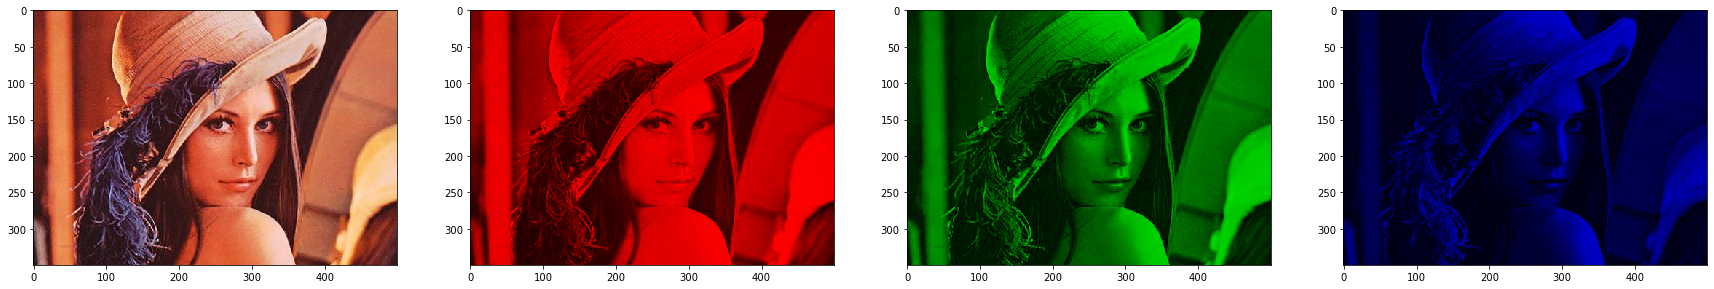

In [11]:
zero = np.zeros(R.shape).astype('uint8')

red_img = cv2.merge((R, zero, zero))
green_img = cv2.merge((zero, G, zero))
blue_img = cv2.merge((zero, zero, B))

plt.figure(figsize=(30,30))
plt.subplot(141)
plt.imshow(merge_img)
plt.subplot(142)
plt.imshow(red_img)
plt.subplot(143)
plt.imshow(green_img)
plt.subplot(144)
plt.imshow(blue_img)
plt.show()

In [24]:
def image_show(image, trans_model=None, location=None, show=False):
    if location is not None:
        plt.subplot(location)
    if trans_model is not None:
        image = cv2.cvtColor(image, trans_model)
    plt.imshow(image)
    if location is None or show:
        plt.show()

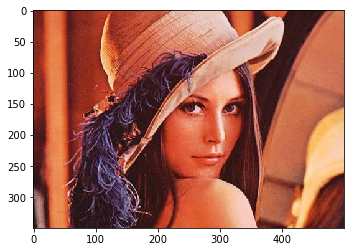

In [25]:
image_show(merge_img) # 图片直接显示

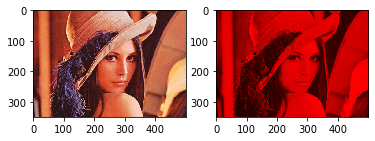

In [26]:
image_show(color_img, trans_model=cv2.COLOR_BGR2RGB, location=121)
image_show(red_img, location=122, show=True)

# 冷色和暖色
`RGB`的缺陷是比较明显的：由三组通道组成。
所以想要调节亮度，饱和度的时候，总会需要同时调整三个通道，而且不够明晰。
但是它的优点也在于此：我们可以添加一些颜色不易被发现，进行冷暖色调调整。
> 当色彩加多，会影响基色偏移，不能加太多

In [29]:
def image_plus(image, r_plus=0, g_plus=0, b_plus=0, RGB=False):
    if not RGB:
        B, G, R = cv2.split(image)
    else:
        R, G, B = cv2.split(image)
    R += r_plus
    G += g_plus
    B += b_plus
    R[R > 255] = 255
    R[R < 0]   = 0
    G[G > 255] = 255
    G[G < 0]   = 0
    B[B > 255] = 255
    B[B < 0]   = 0
    return cv2.merge((R, G, B))

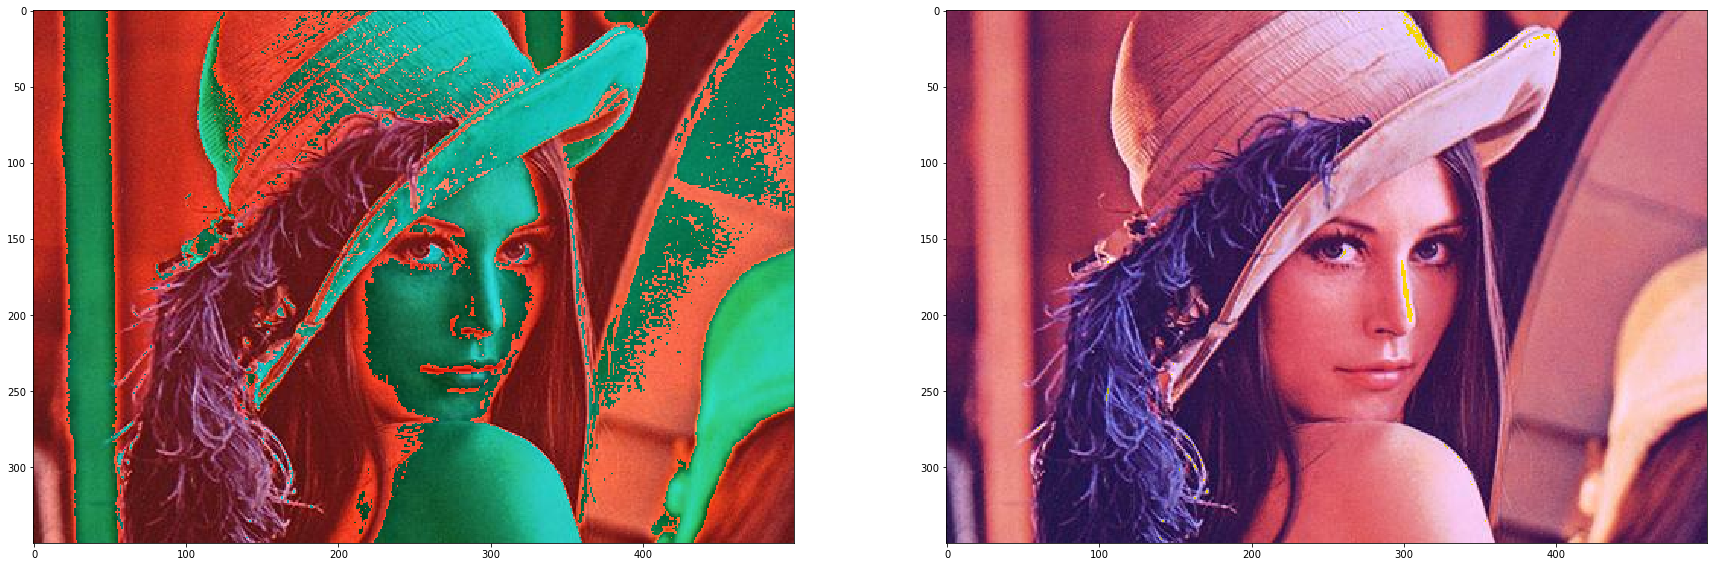

In [280]:
red_plus = image_plus(merge_img, r_plus=50, RGB=True)
blue_plus = image_plus(color_img, b_plus=50)
plt.figure(figsize=(30,30))
image_show(red_plus, location=121)
image_show(blue_plus, location=122, show=True)

# 亮度调整

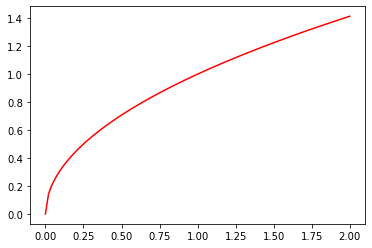

In [49]:
def show_calc():
    x = np.linspace(0, 2, 100)
    y = x ** 0.5
    plt.plot(x, y, color='r')
    plt.show()
    
show_calc()

# Gamma
gamma变换就是按照如上的幕函数进行变换。
可以看到在数值比较低的地方，增长率比较高，那么较暗部分的亮度就会明显增加。
但是亮度大的地方，增长就比较缓慢，亮度增加不明显，刚好可以做图像变亮。

In [40]:
def adjust_gamma(image, gamma=1.0):
    reverse_gamma = 1.0 / gamma
    table = [ (value / 255) ** reverse_gamma * 255 for value in range(256)]
    table = np.array(table).astype('uint8')
    return cv2.LUT(image, table)

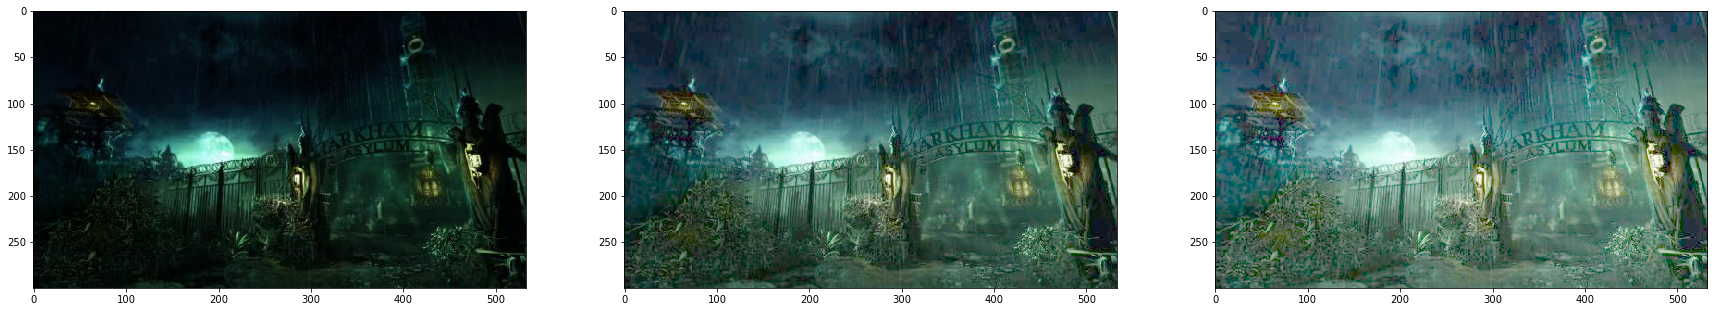

In [52]:
dark_img = cv2.imread('dark.jpg')
gamma_dark = adjust_gamma(dark_img, 2)
gamma_dark_2 = adjust_gamma(dark_img, 3)
plt.figure(figsize=(30,30))
image_show(dark_img, location=131, trans_model=cv2.COLOR_BGR2RGB)
image_show(gamma_dark, location=132, trans_model=cv2.COLOR_BGR2RGB)
image_show(gamma_dark_2, location=133, trans_model=cv2.COLOR_BGR2RGB, show=True)

对于`RGB`来说，它只有亮度和色属，然后两者交合起来。
这样调整的亮度，会明显的产生色相的偏移，和饱和度的变化。
因为对于二者，都是通过基色进行组合而产生的。
一般情况下，可以通过其他颜色空间进行变换。

# 通道调亮

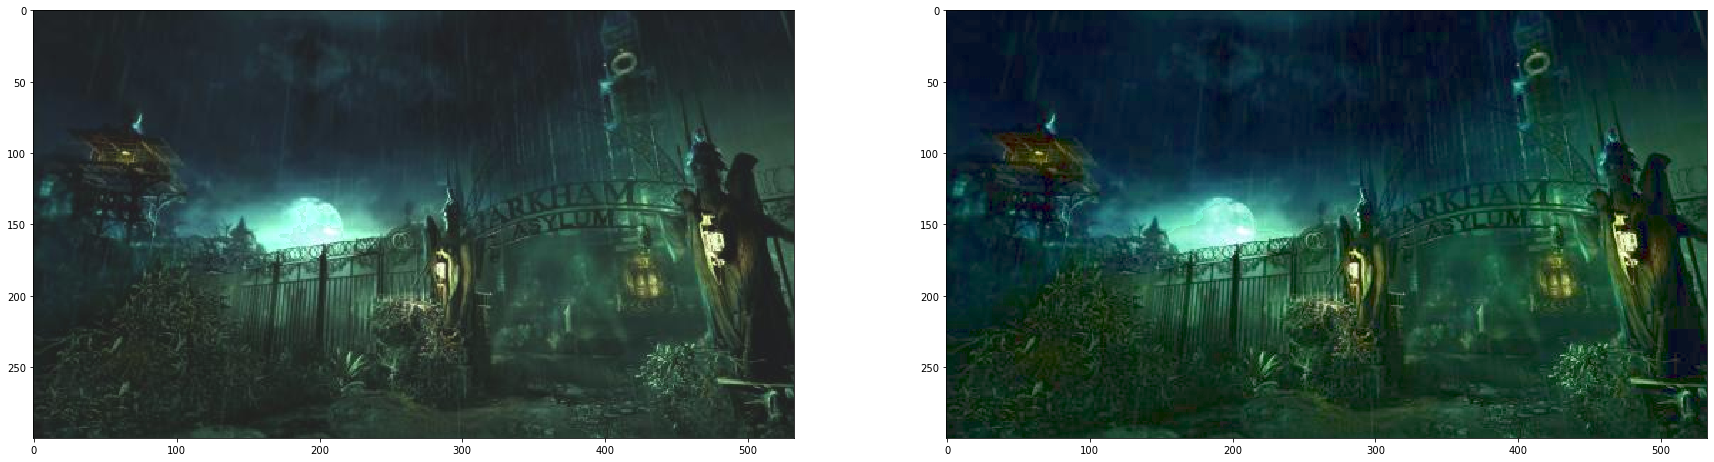

In [159]:
dark_yuv = cv2.cvtColor(dark_img, cv2.COLOR_BGR2YUV)
dark_hsv = cv2.cvtColor(dark_img, cv2.COLOR_BGR2HSV)
# 
y,u,v = cv2.split(dark_yuv)
y[y < 220] += 30
dark_yuv_ = cv2.merge((y,u,v))
#
h,s,v2 = cv2.split(dark_hsv)
v2[v2 < 220] += 30
dark_hsv_ = cv2.merge((h,s,v2))
#
plt.figure(figsize=(30,30))
image_show(dark_yuv_, trans_model=cv2.COLOR_YUV2RGB, location=121)
image_show(dark_hsv_, trans_model=cv2.COLOR_HSV2RGB, location=122, show=True)

> 当亮度超过最大阈值，会从0开始计


经过多中实验后呢，你会发现，使用`YUV`来调节亮度是最好的。
因为它核心是对亮度做调节，其他信息都是色差信息。

- RGB侧重显示，调节不便，影响大
- HSV平易近人，但是只关注单方面，关系保持僵硬

只有`YUV`在明度的调整上，保持来色差关系，在调节亮度的同时让画面不至于那么僵硬。

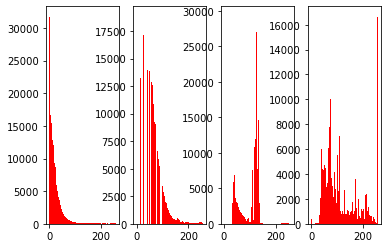

In [160]:
plt.subplot(141)
plt.hist(dark_img.flatten(), 255, [0, 256], color='r')
plt.subplot(142)
plt.hist(gamma_dark.flatten(), 255, [0, 256], color='r')
plt.subplot(143)
plt.hist(dark_yuv_.flatten(), 255, [0, 256], color='r')
plt.subplot(144)
plt.hist(dark_hsv_.flatten(), 255, [0, 256], color='r')
plt.show()

可以看到调整亮度，做的其实就是调整色阶分布。但是容易失去事物原本对比的韵味。

# 换色

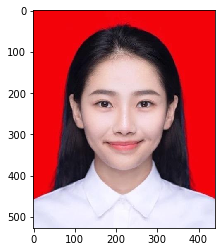

In [65]:
photo = cv2.imread('photo.jpg')
image_show(photo, trans_model=cv2.COLOR_BGR2RGB)

In [110]:
photo_hsv = cv2.cvtColor(photo, cv2.COLOR_BGR2HSV)
photo_hsv

array([[[179, 253, 243],
        [179, 253, 243],
        [179, 253, 243],
        ...,
        [179, 253, 243],
        [179, 253, 243],
        [179, 253, 243]],

       [[179, 253, 243],
        [179, 253, 243],
        [179, 253, 243],
        ...,
        [179, 253, 243],
        [179, 253, 243],
        [179, 253, 243]],

       [[179, 253, 243],
        [179, 253, 243],
        [179, 253, 243],
        ...,
        [179, 253, 243],
        [179, 253, 243],
        [179, 253, 243]],

       ...,

       [[118,  19, 251],
        [118,  19, 251],
        [118,  19, 252],
        ...,
        [123,  21, 255],
        [123,  21, 253],
        [123,  21, 251]],

       [[118,  19, 252],
        [118,  19, 252],
        [118,  19, 252],
        ...,
        [123,  20, 255],
        [123,  21, 254],
        [123,  21, 252]],

       [[118,  19, 252],
        [118,  19, 252],
        [118,  19, 253],
        ...,
        [123,  20, 255],
        [123,  21, 254],
        [123,  21, 252]]

![img](hsv_color.jpg)

| color                | angle                |
| ---------------------| ---------------------| 
| `red`                | [0, 60]              |
| `yello`              | [60, 120]            |
| `green`              | [120, 180]           |
| `cyan`               | [180, 240]           |
| `blue`               | [240, 300]           |
| `magenta`            | [300, 360]           |



In [148]:
h,s,v = cv2.split(photo_hsv)
# 理论图片好像不很准啊，没办法
h[(h > 150) & (h < 190)] += 180
trans = cv2.merge((h,s,v))

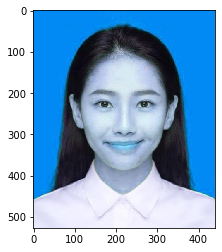

In [149]:
image_show(trans, trans_model=cv2.COLOR_HSV2RGB)
# 卧槽，怎么这么像遗照，尴尬😅

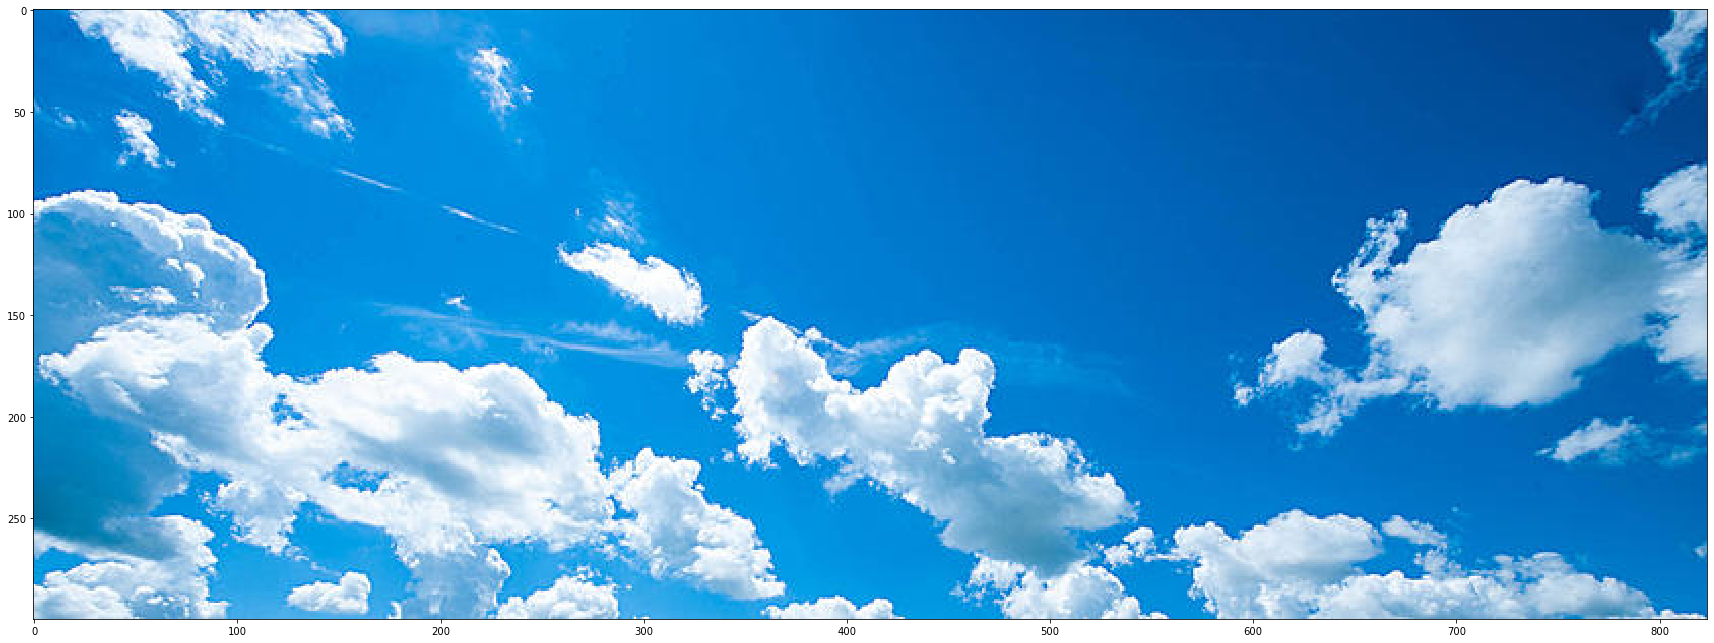

In [272]:
sky_img = cv2.imread('sky.jpg')
plt.figure(figsize=(30,30))
image_show(sky_img, trans_model=cv2.COLOR_BGR2RGB)

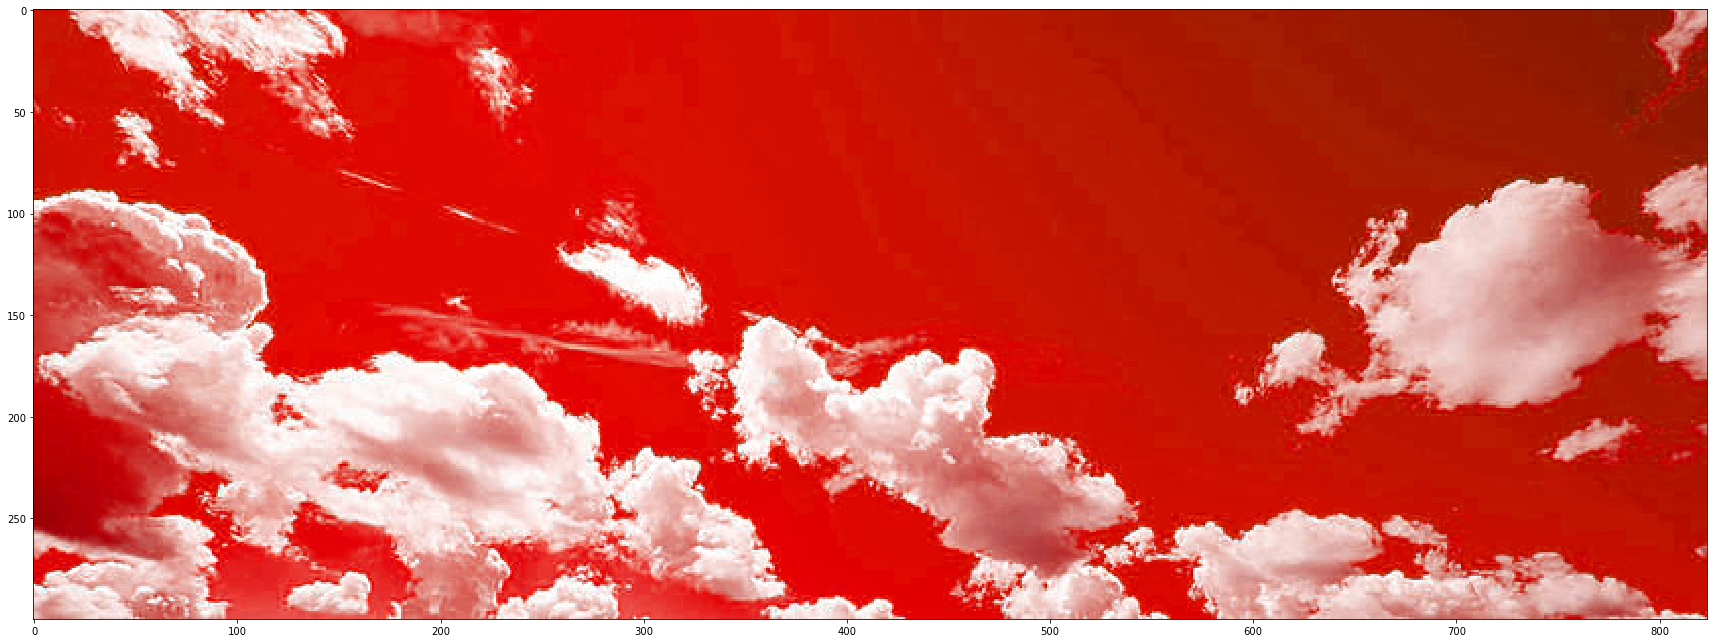

In [279]:
sky_h, sky_s, sky_v = cv2.split(cv2.cvtColor(sky_img, cv2.COLOR_BGR2HSV))
sky_h[(sky_h > 90) & (sky_h < 130)] += 80
plt.figure(figsize=(30,30))
image_show(cv2.merge((sky_h,sky_s, sky_v)), trans_model=cv2.COLOR_HSV2RGB)